In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_svmlight_file

In [11]:
# This section is implementation of adaboost and log-boost.
# in code below:
#   X means features of samples
#   Y means label of samples
#   W means the weight of samples
#   T means total number of boosting iterations
def stumpClassify(X, feature, threshVal, ineq):
    '''
    classify the X based on threshold
    '''
    ret = np.ones(np.shape(X)[0])
    if ineq == '>=':
        ret[X[:, feature] >= threshVal] = -1.0
    else:
        ret[X[:, feature] <  threshVal] = -1.0
    return ret

def buildStump(X, Y, W):
    '''
    find the boosting stump with lowest error
    '''
    m, n = np.shape(X)
    bestStump = {}
    bestClsEst = np.zeros(m)
    minError = np.inf
    for i in range(n):
        thresh_range = np.unique(X[:,i])
        # we are using this threshold range because it is the smallest range that can distinguish all values of the feature in train sample
        for thresh in thresh_range:
            for ineq in ['>=', '<']:
                predictedVals = stumpClassify(X, i, thresh, ineq)
                errArr = np.ones(m)
                errArr[predictedVals == Y] = 0
                weighed_error = np.dot(W, errArr)
                if weighed_error < minError:
                    minError = weighed_error
                    bestClsEst = predictedVals.copy()
                    bestStump['feature']  = i
                    bestStump['thresh']   = thresh
                    bestStump['ineq']     = ineq
    bestStump['alpha'] = float(0.5 * np.log((1-minError)/minError))
    return bestStump, minError, bestClsEst

def boost(X, Y, Xtest, Ytest, T=500, type='ada'):
    # initialization the boosting algorithm
    m, n = np.shape(X)
    W = np.ones(m)/m
    weakclassifiers = []
    addEstTrain = np.zeros(m)

    # the following variables record the training error rate and the test error rate
    addEstTest  = np.zeros(Xtest.shape[0])
    train_error_rates = []
    test_error_rates  = []
    for t in range(T):
        # if t%100 == 0: print(t)
        # finding the best stumps
        bestStump, error, classEst = buildStump(X, Y, W)
        weakclassifiers.append(bestStump)
        # reweighting
        addEstTrain = addEstTrain + bestStump['alpha'] * classEst
        addEstTest  = addEstTest  + bestStump['alpha'] * stumpClassify(Xtest, bestStump['feature'], bestStump['thresh'], bestStump['ineq'])
        if type == 'ada':
            W = np.exp(-1 * Y * addEstTrain)
        else: # type == 'log'
            W = 1/(1 + np.exp(Y * addEstTrain))
        W = W/np.sum(W)
        # recording train_error_rates and test_error_rates
        train_error_rates.append(error_rate(Y, binary_pred(addEstTrain)))
        test_error_rates.append(error_rate(Ytest, binary_pred(addEstTest)))

    return weakclassifiers, train_error_rates, test_error_rates

def binary_pred(Est, margin=0):
    return np.where(Est >= margin,1.,-1.)

def error_rate(Y, pred):
    ret = 0
    for i in range(len(pred)):
        if Y[i]!=pred[i]: ret+=1
    return ret/len(Y)

def predict(X, weakclassifiers):
    m = X.shape[0]
    addEst = np.zeros(m)
    for weak in weakclassifiers:
        weakEst = stumpClassify(X, weak['feature'], weak['thresh'], weak['ineq'])
        addEst += weak['alpha']*weakEst
        
def draw_results(df, title):
    plot = df.plot(title=title,grid=True)
    plot.set_ylabel('Error rates')
    plot.set_xlabel('Iterations')
    plt.savefig(title)

In [12]:
# load data
Xtrain, Ytrain = load_svmlight_file('train.scaled')
Xtest, Ytest = load_svmlight_file('test.scaled')
Xtrain = Xtrain.A; Xtest  = Xtest.A

In [13]:
# A simple run for adaboost
classifiers, train_rates, test_rates = boost(Xtrain, Ytrain, Xtest, Ytest,T=1200, type='ada')
ada = pd.DataFrame({'train_error': train_rates, 'test_error': test_rates})

In [14]:
# A simple run for log-boost
classifiers, train_rates, test_rates = boost(Xtrain, Ytrain, Xtest, Ytest,T=1200, type='log')
log = pd.DataFrame({'train_error': train_rates, 'test_error': test_rates})

In [15]:
def cross_validation(X, Y, type, split=10 ,T=800):
    # split X and Y in to 'split' subsamples.
    n_sample = X.shape[0]
    sub_size = n_sample/split
    random_indices = np.array(range(n_sample))
    random.shuffle(random_indices)
    cross_validation_error = []
    
    # do cross validation on splitted samples
    for i in range(split):
        test_range = np.array(random_indices[int(i*sub_size): int((i+1)*sub_size)])
        train_range = np.delete(random_indices, test_range)
        Xtest = X[test_range]
        Ytest = Y[test_range]
        Xtrain = X[train_range]
        Ytrain = Y[train_range]
        useless, useless, error = boost(Xtrain, Ytrain, Xtest, Ytest, T=T, type=type)
        cross_validation_error.append(error)
    return np.array(cross_validation_error)

In [16]:
# A simple run for cross validation
ada_cross_validation = cross_validation(Xtrain,Ytrain, type='ada', T=1200)
log_cross_validation = cross_validation(Xtrain,Ytrain, type='log', T=1200)

In [17]:
# plot the cross validation results
ada_mean = np.mean(ada_cross_validation, axis=0)
ada_std  = np.std(ada_cross_validation, axis=0)
log_mean = np.mean(log_cross_validation,axis=0)
log_std  = np.std(log_cross_validation, axis=0)

ada_ = pd.DataFrame({
    'mean':ada_mean,
    '+1std': ada_mean + ada_std,
    '-1std': ada_mean - ada_std
})

log_ = pd.DataFrame({
    'mean':log_mean,
    '+1std': log_mean + log_std,
    '-1std': log_mean - log_std
})

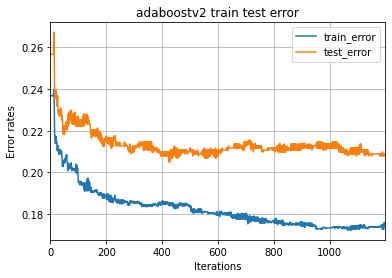

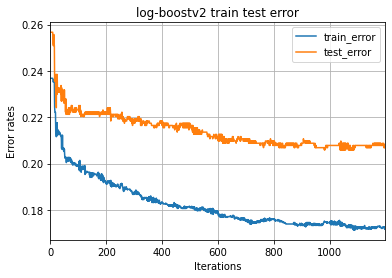

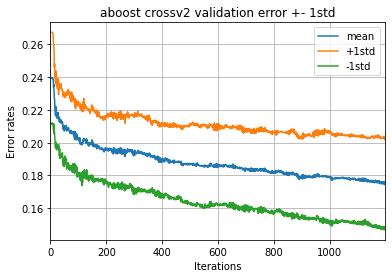

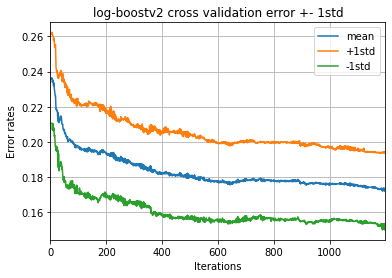

In [18]:
draw_results(ada, 'adaboostv2 train test error')
draw_results(log, 'log-boostv2 train test error')
draw_results(ada_, 'aboost crossv2 validation error +- 1std')
draw_results(log_, 'log-boostv2 cross validation error +- 1std')